# Ungraded Lab: Build a Multi-output Model

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow-Advanced_Techniques_Specialization/blob/master/Custom_Models_Layers_and_Loss_Functions_with_TensorFlow/Week1/Labs/C1_W1_Lab_2_multi-output.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import layers, Input, Model, optimizers, metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2024-08-21 16:45:03.433772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 16:45:03.445855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 16:45:03.449643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 16:45:03.457511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    
    return y1, y2

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend(["Training", "Validation"])
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = layers.Dense(units=128, activation='relu')(input_layer)
second_dense = layers.Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = layers.Dense(units=1, name='y1_output')(second_dense)
third_dense = layers.Dense(units=64, activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = layers.Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

2024-08-21 16:45:05.213560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1749 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      1,152 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_output (Dense)   │ (None, 1)         │        129 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2_output (Dense)   │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,114 (102.01 KB)

 Trainable params: 26,114 (102.01 KB)

 Non-trainable params: 0 (0.00 B)

None


## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': metrics.RootMeanSquaredError(),
                       'y2_output': metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500


I0000 00:00:1724280306.313775  145552 service.cc:146] XLA service 0x7c64c0004e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724280306.313800  145552 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-08-21 16:45:06.329259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 16:45:06.390841: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 620.3140 - y1_output_loss: 295.6390 - y1_output_root_mean_squared_error: 16.6286 - y2_output_loss: 324.6750 - y2_output_root_mean_squared_error: 17.4252

I0000 00:00:1724280307.045771  145552 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 597.5911 - y1_output_loss: 284.7035 - y1_output_root_mean_squared_error: 16.2790 - y2_output_loss: 312.8461 - y2_output_root_mean_squared_error: 17.0665 - val_loss: 198.5734 - val_y1_output_loss: 43.4074 - val_y1_output_root_mean_squared_error: 6.6950 - val_y2_output_loss: 149.7795 - val_y2_output_root_mean_squared_error: 12.3996
Epoch 2/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56.2740 - y1_output_loss: 18.9026 - y1_output_root_mean_squared_error: 4.3244 - y2_output_loss: 37.3611 - y2_output_root_mean_squared_error: 6.0548 - val_loss: 15.9559 - val_y1_output_loss: 6.4237 - val_y1_output_root_mean_squared_error: 2.5302 - val_y2_output_loss: 9.4012 - val_y2_output_root_mean_squared_error: 3.0909
Epoch 3/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37.2748 - y1_output_loss: 10.9478 - y1_output_root_mean_squared_error: 3.3025 - y2_output_loss: 26.3367 - y2_output_root_mean_squared_error: 5.0436 - val_loss: 18.2220 - val_y1_out

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.7661 - y1_output_loss: 0.5392 - y1_output_root_mean_squared_error: 0.7339 - y2_output_loss: 1.2259 - y2_output_root_mean_squared_error: 1.1057
Loss = 1.9176366329193115, Y1_loss = 0.5619441866874695, Y1_mse = 0.7487193942070007, Y2_loss = 1.352609395980835, Y2_mse = 1.1649274826049805


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


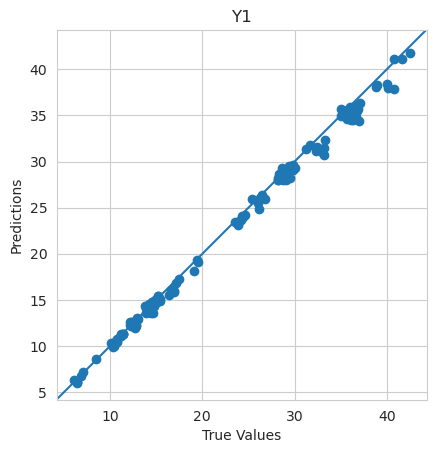

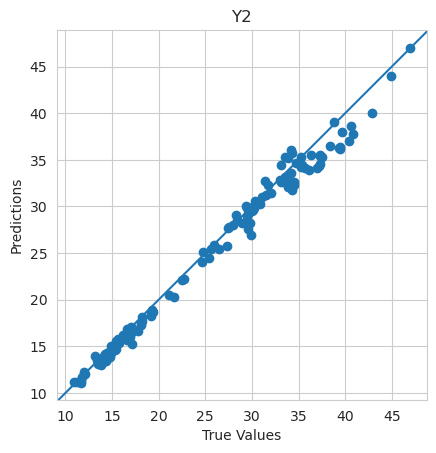

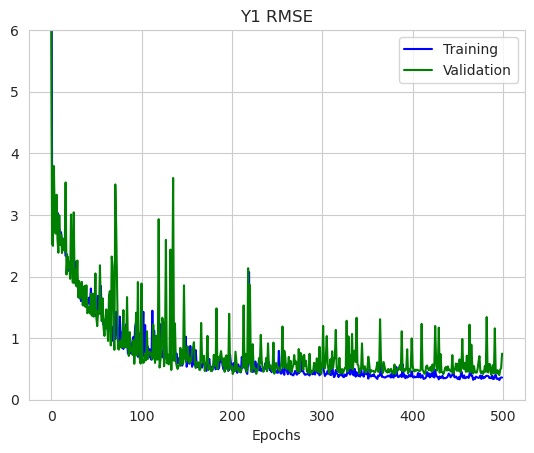

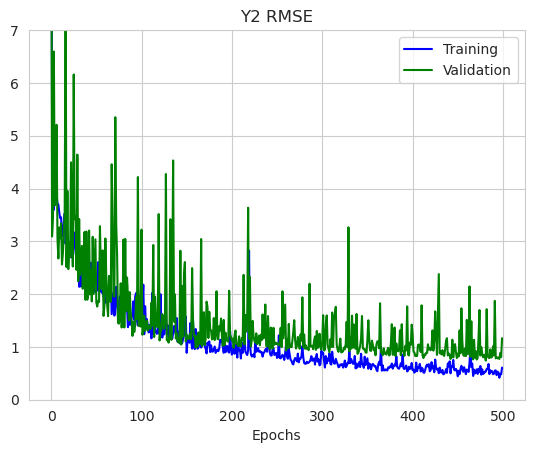

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)